# Validating approximate thermal model

To validate the thermal model I finished deriving yesterday, I would like to compare it with the IEEE 738 standard calculation. This is a coding exercise.

## Summary of line temperature constraint

Suppose our time horizon consists of $n$ intervals, each on the order of ten minutes long. Power flow data is updated after each interval, but all other parameters remain constant. We choose a single transmission line in the network, the line between nodes $i$ and $j$. This line has a thermal limit of $T_\text{lim}$ degrees Celsius.

\begin{align}
T(t_n) &= f + \frac{c}{a}\left[ \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)\theta_{ij}(t_{n-i+1})^2\right]
\end{align}

where

* $\hat{\theta}_{ij}(t_{k})=  \theta_{ij}(t_k)\sqrt{ (e^{(t_1-t_0)a})^{n-k+1} - (e^{(t_1-t_0)a})^{n-k} } $
    * $\theta_{ij}(t_k)$ is the angle difference across line $ij$ at time interval $t_k$.
    * $t_1-t_0$ is the length of each time interval (in seconds)
* $a = \frac{1}{mC_p}\left[ -\eta_c - 4\eta_r(T_\text{mid} + 273)^3 \right]$ has units of $s^{-1}$
    * $mC_p$ is the heat capacity, with units of J/m-$^\circ$C
    * $\eta_c$ is the conductive heat loss rate coefficient, with units of W/m-$^\circ$C
    * $\eta_r$ is the conductive heat loss rate coefficient, with units of W/m-$^\circ$C$^4$
    * $T_\text{mid}$ is the average of ambient temperature $T_\text{amb}$ and limit temperature $T_\text{lim}$, in Celsius
* $c = \frac{r_{ij}S_b}{3 mC_p x_{ij}^2L_{ij}}$ is a constant with units of W/m
    * $r_{ij}$ is resistance of line $ij$ in per unit
    * $x_{ij}$ is reactance of line $ij$ in per unit
    * $S_b$ is the system base (e.g. 100 MVA)
    * $L_{ij}$ is the length of one phase of line $ij$, in m
* $f = (e^{(t_1 - t_0)a})^n T(t_0) + \frac{d}{a}\left[ \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)\right]$ is a constant with units of degrees Celsius
    * $T(t_0)$ is the line's initial temperature (steady state temperature under base case power flow condition)
    * $d = \frac{1}{mC_p}\left[ \eta_cT_\text{amb} - \eta_r\left((T_\text{mid} + 273)^4 - (T_\text{amb} + 273)^4\right) + 4\eta_rT_\text{mid}(T_\text{mid} + 273)^3 + q_s \right]$ 
    
    is a constant with units of W/m
        * $q_s$ is the solar heat gain rate in W/m

In [6]:
function compute_a(mCp,ηc,ηr,Tamb,Tlim)
    """ Returns constant a [1/s]
    mCp [J/m-C] is line heat capacity
    ηc [W/m-C] is conductive heat loss rate coefficient
    ηr [W/m-C^4] is radiative heat loss rate coefficient
    Tamb [C] is ambient temperature (of air)
    Tlim [C] is highest allowable line temperature
    """
    Tmid = (Tamb + Tlim)/2
    return mCp\(-ηc - 4*ηr*(Tmid + 273)^3)
end

function compute_c(mCp,r,x,Sb,L)
    """ Return constant c [W/m]
    mCp [J/m-C] is line heat capacity
    r [pu] is line resistance
    x [pu] is line reactance
    Sb [W] is system base MVA
    L [m] is line length
    """
    return r*Sb/(3*mCp*L*x^2)
end

function compute_d(mCp,ηc,ηr,Tamb,Tlim,q_solar)
    """ Returns constant d [W/m]
    mCp [J/m-C] is line heat capacity
    ηc [W/m-C] is conductive heat loss rate coefficient
    ηr [W/m-C^4] is radiative heat loss rate coefficient
    Tamb [C] is ambient temperature (of air)
    Tlim [C] is highest allowable line temperature
    q_solar [W/m] is the solar heat gain rate
    """
    Tmid = (Tamb + Tlim)/2
    return mCp\(ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb + 273)^4) + 4*ηr*Tmid*(Tmid+273)^3 + q_solar)
end

function compute_f(int_length,a,d,n,T0)
    """ Returns constant f
    int_length [s] is length of each interval
    a [1/s] is a constant
    d [W/m] is a constant
    n [-] is the number of time intervals
    T0 [C] is the initial steady-state line temp
    """
    sum_coeff = sum([(e^(int_length*a))^i - (e^(int_length*a))^(i-1) for i in 1:n])
    return (e^(int_length*a))^n*T0 + (d/a)*sum_coeff
end

function compute_T(int_length,a,c,f,n,θij)
    """ Return line's final temperature
    int_length [s] is length of each interval
    a [1/s] is a constant
    c [W/m] is a constant
    f [C] is a constant
    n [-] is the number of time intervals
    θij [rad] is the vector of angle differences (sorted by time interval)
    """
    angle_coeffs = [(e^(int_length*a))^i - (e^(int_length*a))^(i-1) for i in 1:n]
    return f + (c/a)*dot(angle_coeffs,flipud(θij).^2)
end

compute_T (generic function with 1 method)

# The functions above reproduce numerical results from yesterday

Using the same input data, I will compare the new formulation to the one I derived two days ago. If my derivation is correct, the final temperatures computed by the two sets of equations should match (the two formulations are equivalent).

The following code performs this validation. Vary angle differences across three time intervals to repeat the calculations, and note that the two values always match. This means I can switch over from the older formulation (in which angle differences were buried) to the new formulation (where angle differences are exposed). The new formulation is ready to be used in our optimization framework.

In [1]:
using Interact
using PyPlot

INFO: Loading help data...


In [2]:
# Input data comes from Waxwing conductors on RTS-96 network:
Tamb = 35. # C
Tlim = 65. # C
Tmid = (Tamb + Tlim)/2 # C
T0 = 46. # initial line steady-state temp
ηc = 0.955 # W/m-C
ηr = 2.207e-9 # W/m-C^4
mCp = 383. # J/m-C
r_ij = 0.03 # pu (typical value)
x_ij = 0.1 # pu (typical value)
qs = 14.4 # W/m
L_ij = 50e3 # 50 km line
Sb = 100e6 # 100 MVA base
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps
int_length = 600. # seconds

600.0

In [7]:
# Compute constants used in new formulation:
a = compute_a(mCp,ηc,ηr,Tamb,Tlim)
c = compute_c(mCp,r_ij,x_ij,Sb,L_ij)
d = compute_d(mCp,ηc,ηr,Tamb,Tlim,qs)
f = compute_f(int_length,a,d,time_intervals,T0)

46.7467589264431

In [22]:
# Use sliders to vary angle differences corresponding to three time intervals.
# The code will compute final line temperature using two different sets of equations.
# Regardless of slider positions, the two numbers match.
# This verifies that the two formulations are equivalent, as desired.
@manipulate for θij1 in 0:0.01:0.15, θij2 in 0:0.01:0.15, θij3 in 0:0.01:0.15
    # Compute final temperature with new method:
    θij_vals = [θij1,θij2,θij3]
    Tfinal1 = compute_T(int_length,a,c,f,time_intervals,θij_vals)
    
    # Compute final temperature with old method:
    angle_diffs = [θij1,θij2,θij3]
    f_loss_pu_values = [r_ij*(θij/x_ij)^2 for θij in angle_diffs] # pu
    f_loss_si_values = f_loss_pu_values.*Sb/(3*L_ij) # W/m
    b_values = [mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs ) for f_loss_si in f_loss_si_values]
    Tfinal2 = exp(600*a)^3*(T0 + b_values[1]/a) + exp(600*a)^2*(-b_values[1]/a + b_values[2]/a) + exp(600*a)*(-b_values[2]/a + b_values[3]/a) - b_values[3]/a
    
    # Compare results of the two calculations:
    [Tfinal1,Tfinal2]
    end

Slider{Float64}([Input{Float64}] 0.07,"θij1",0.07,0.0:0.01:0.15)

Slider{Float64}([Input{Float64}] 0.07,"θij2",0.07,0.0:0.01:0.15)

Slider{Float64}([Input{Float64}] 0.07,"θij3",0.07,0.0:0.01:0.15)

2-element Array{Float64,1}:
 54.5383
 54.5383

# Comparison with IEEE 738 thermal model

There is one last check that must be performed before I can confidently use the approximate thermal model. I need to compare it numerically to the IEEE 738 thermal model. If the two models compute similar temperatures, I will begin using the approximate thermal model in the temporal instanton framework.

## Summary of IEEE 738 temperature calculation

IEEE recommends integrating the following heat balance equation to compute changes in line temperature:

\begin{align}
\frac{dT_\text{avg}}{dt} &= \frac{1}{mC_p}\left(I^2R(T_\text{avg}) - q_c - q_r + q_s\right)
\end{align}

Substitute the approximate DC loss expression:

\begin{align}
\frac{dT_\text{avg}}{dt} &= \frac{1}{mC_p}\left( r_{ij}\frac{\theta_{ij}^2}{x_{ij}^2}\frac{S_b}{3L_{ij}} - q_c - q_r + q_s\right)
\end{align}

Heat rates $q_c$ and $q_r$ are calculated as follows:

\begin{align}
q_c &= \eta_c\cdot(T - T_\text{amb}) \\
q_r &= \eta_r\cdot((T + 273)^4 - (T_\text{amb} + 273)^4)
\end{align}

The angle difference $\theta_{ij}$ is fixed every ten minutes. Within each ten-minute period, we use Euler integration with a time step of one minute to compute the temperature change. The final temperature of each ten-minute interval becomes the initial temperature of the next.

In [ ]:
# Input data comes from Waxwing conductors on RTS-96 network:
Tamb = 35. # C
Tlim = 65. # C
Tmid = (Tamb + Tlim)/2 # C
T0 = 46. # initial line steady-state temp
ηc = 0.955 # W/m-C
ηr = 2.207e-9 # W/m-C^4
mCp = 383. # J/m-C
r_ij = 0.03 # pu (typical value)
x_ij = 0.1 # pu (typical value)
qs = 14.4 # W/m
L_ij = 50e3 # 50 km line
Sb = 100e6 # 100 MVA base
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps
int_length = 600. # seconds

In [10]:
function compute_q_c(T,Tamb,ηc)
    return ηc*(T - Tamb)
end

function compute_q_r(T,Tamb,ηr)
    return ηr*((T + 273).^4 - (Tamb + 273)^4)
end

function compute_delta_T(mCp,θij,r,x,Sb,L,q_c,q_r,q_s)
    f_loss_si = r*(θij/x)^2*(Sb/(3*L))
    return mCp\(f_loss_si - q_c - q_r + q_s)
end

function rad_rate_approx(T,Tamb,Tlim,ηr)
    Tmid = (Tamb + Tlim)/2
    return ηr*((Tmid + 273).^4 - (Tamb + 273).^4) + (4*ηr*(Tmid + 273).^3)*(T - Tmid)
end

rad_rate_approx (generic function with 1 method)

Slider{Float64}([Input{Float64}] 0.07,"θij1",0.07,0.0:0.01:0.15)

Slider{Float64}([Input{Float64}] 0.07,"θij2",0.07,0.0:0.01:0.15)

Slider{Float64}([Input{Float64}] 0.07,"θij3",0.07,0.0:0.01:0.15)

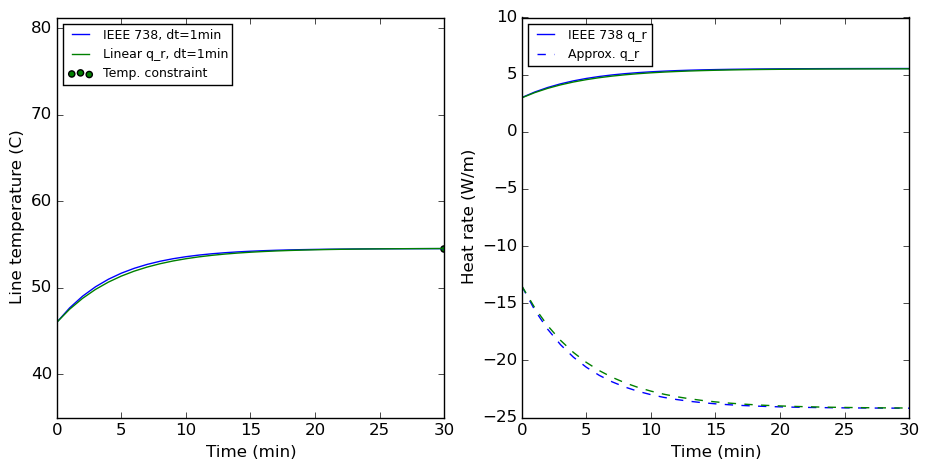

In [65]:
T_approx(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP

# Use sliders to vary angle differences corresponding to three time intervals.
# The code will compute final line temperature using two different sets of equations.
# Regardless of slider positions, the two numbers match.
# This verifies that the two formulations are equivalent, as desired.
fig = figure(figsize=(11,5))
@manipulate for θij1 in 0:0.01:0.15, θij2 in 0:0.01:0.15, θij3 in 0:0.01:0.15; withfig(fig) do
        # Compute final temperature with new method:
        θij_vals = [θij1,θij2,θij3]
        Tfinal1 = compute_T(int_length,a,c,f,time_intervals,θij_vals)

        # Compute temperature with IEEE 738 standard
        T738 = [T0]
        for int in 1:time_intervals
            for t in 1:10
                T = T738[end]
                q_c = compute_q_c(T,Tamb,ηc)
                q_r = compute_q_r(T,Tamb,ηr)

                delta_T = compute_delta_T(mCp,θij_vals[int],r_ij,x_ij,Sb,L_ij,q_c,q_r,qs)
                T738 = [T738,T738[end] + 60*delta_T] # delta_T constant for 60 seconds
            end
        end
        
        Tapprox = [T0]
        T_0 = T0
        for θij in θij_vals
            f_loss_pu = r_ij*(θij/x_ij)^2 # pu
            f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
            b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
            Tapprox = [Tapprox,T_approx(time_values,T_0,a,b)[2:end]]
            T_0 = Tapprox[end]
        end

        # Compare results of the two calculations:
        #[Tfinal1,T738[end]]
        subplot(121)
        plot(T738)
        hold=true
        plot(Tapprox)
        scatter([30],[Tfinal1],c="green")
        legend(["IEEE 738, dt=1min","Linear q_r, dt=1min","Temp. constraint"],loc=2,fontsize=9)
        axis([0,30,Tamb,Tlim*1.25])
        xlabel("Time (min)")
        ylabel("Line temperature (C)")
        
        # Difference is due to radiative heat loss rate
        q_rad_738 = compute_q_r(T738,Tamb,ηr)
        q_rad_approx = rad_rate_approx(Tapprox,Tamb,Tlim,ηr)
        # fig2 = figure()
        subplot(122)
        plot(q_rad_738)
        hold=true
        plot(-compute_q_c(T738,Tamb,ηc) - q_rad_738,"b--")
        plot(q_rad_approx)
        plot(-compute_q_c(Tapprox,Tamb,ηc) - q_rad_approx,"g--")
        legend(["IEEE 738 q_r","Approx. q_r"],loc=2,fontsize=9)
        xlabel("Time (min)")
        ylabel("Heat rate (W/m)")
    end
end

My approximate model is slower to heat up and slower to cool off. There are two differences between the models:

* my model uses a linear approximation for radiative heat loss rate.
* my model uses the analytic solution of an IVP rather than numerical integration

Because my model was designed to be conservative, the line temperature should be consistently higher. It is possible, however, to obtain higher temperatures from the IEEE 738 model than with mine. I believe this is due to the time step used with the 738 model. To test this hypothesis, I will use a significantly smaller time step for numerical integration.

Slider{Float64}([Input{Float64}] 0.07,"θij1",0.07,0.0:0.01:0.15)

Slider{Float64}([Input{Float64}] 0.07,"θij2",0.07,0.0:0.01:0.15)

Slider{Float64}([Input{Float64}] 0.07,"θij3",0.07,0.0:0.01:0.15)

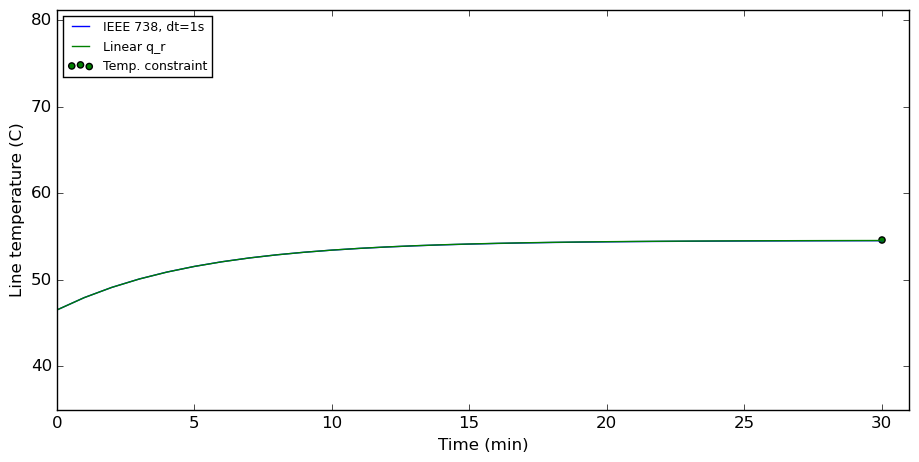

In [17]:
T_approx(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP
T0 = 46.5
# Use sliders to vary angle differences corresponding to three time intervals.
# The code will compute final line temperature using two different sets of equations.
# Regardless of slider positions, the two numbers match.
# This verifies that the two formulations are equivalent, as desired.
fig = figure(figsize=(11,5))
@manipulate for θij1 in 0:0.01:0.15, θij2 in 0:0.01:0.15, θij3 in 0:0.01:0.15; withfig(fig) do
        # Compute final temperature with new method:
        θij_vals = [θij1,θij2,θij3]
        Tfinal1 = compute_T(int_length,a,c,f,time_intervals,θij_vals)

        # Compute temperature with IEEE 738 standard
        T738 = [T0]
        for int in 1:time_intervals
            for t in 1:10 # for each minute
                inter_temp = T738[end]
                for s in 1:60 # integrate with 1 second time step
                    q_c = compute_q_c(inter_temp,Tamb,ηc)
                    q_r = compute_q_r(inter_temp,Tamb,ηr)
                    delta_T = compute_delta_T(mCp,θij_vals[int],r_ij,x_ij,Sb,L_ij,q_c,q_r,qs)
                    inter_temp += delta_T
                end
                T738 = [T738,inter_temp]
            end
        end
        
        Tapprox = [T0]
        T_0 = T0
        for θij in θij_vals
            f_loss_pu = r_ij*(θij/x_ij)^2 # pu
            f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
            b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
            Tapprox = [Tapprox,T_approx(time_values,T_0,a,b)[2:end]]
            T_0 = Tapprox[end]
        end

        # Compare results of the two calculations:
        # subplot(121)
        plot(T738)
        hold=true
        plot(Tapprox)
        scatter([30],[Tfinal1],c="green")
        legend(["IEEE 738, dt=1s","Linear q_r","Temp. constraint"],loc=2,fontsize=9)
        axis([0,31,Tamb,Tlim*1.25])
        xlabel("Time (min)")
        ylabel("Line temperature (C)")
    end
end

My hypothesis was correct. The most important reason why my model exhibits slower heating and slower cooling is that it uses an analytic differential equation solution. When I increased the sample rate of numerical integration by a factor of 60, the gap between the two models shrank. As the above figure shows, my model is conservative.

I am now comfortable using my approximate line heating model in the temporal instanton optimization framework.